In [1]:
from fundamental_functions import *
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from photutils import CircularAperture
from photutils import aperture_photometry
import numpy as np

In [2]:
# The data
cube2 = 'FINAL_DATACUBE.fits'
hdu2 = F.open(cube2)
data = hdu2[1].data

In [3]:
#QSO redshift
zqso = 3.006
#Coordinate of centre of QSO (pix)
xqso = 225
yqso = 231


#Wavelength slice (in pixels) for PSF fitting/subtraction
wave_slice=120

#Central wavelength for PSF fitting (ang)
lamcen_psf =  6198.0

#PSF flux scaling box size (pix)
r_psf_scale = 6

#PSF subtraction box size (pix)
#Ideally 5x seeing
r_psf_sub = 15

#Velocity search window (wrt LyA; km/s)
vmin=-11000.0/1.5
vmax=5000.0

In [4]:
nw, nx, ny = data.shape
initial_lamb = hdu2[1].header['CRVAL3']

wavearr = np.arange(0.0, nw,1.0) * 1.25 + initial_lamb
ind1_lamcen_psf = int(1152 - wave_slice/2.0)
ind2_lamcen_psf = int(1152 + wave_slice/2.0)

print(wavearr[ind1_lamcen_psf], wavearr[ind2_lamcen_psf])

6115.4140625 6265.4140625


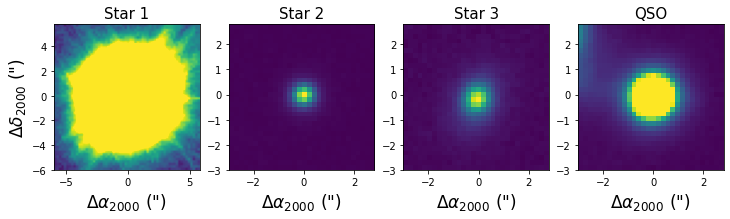

In [7]:
# Selecting the stars :D
x_s1 = 303
y_s1 = 303

x_s2 = 240
y_s2 = 188

x_s3 = 122
y_s3 = 323

star1_off = data[ind1_lamcen_psf:ind2_lamcen_psf, (y_s1-r_psf_sub*2):(y_s1+r_psf_sub*2), 
                (x_s1-r_psf_sub*2):(x_s1+r_psf_sub*2)].sum(axis=0)*1.25

star2_off = data[ind1_lamcen_psf:ind2_lamcen_psf, (y_s2-r_psf_sub):(y_s2+r_psf_sub), 
                (x_s2-r_psf_sub):(x_s2+r_psf_sub)].sum(axis=0)*1.25

star3_off = data[ind1_lamcen_psf:ind2_lamcen_psf, (y_s3-r_psf_sub):(y_s3+r_psf_sub), 
                (x_s3-r_psf_sub):(x_s3+r_psf_sub)].sum(axis=0)*1.25

qso_data = data[ind1_lamcen_psf:ind2_lamcen_psf, (xqso-r_psf_sub):(xqso+r_psf_sub), 
                (yqso-r_psf_sub):(yqso+r_psf_sub)].sum(axis=0)*1.25
                
x = np.arange(-15,15)*0.2
y = np.arange(-15,15)*0.2
x2 = np.arange(-30,30)*0.2
y2 = np.arange(-30,30)*0.2

plt.figure(figsize=(12,8))

plt.subplot(141)
plt.imshow(star1_off, origin='lower', extent=[x2[0],x2[-1],y2[0],y2[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.title('Star 1', fontsize=15)
plt.clim(-100,1000)

plt.subplot(142)
plt.imshow(star2_off, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.title('Star 2', fontsize=15)

plt.subplot(143)
plt.imshow(star3_off, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.title('Star 3', fontsize=15)

plt.subplot(144)
plt.imshow(qso_data, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.title('QSO', fontsize=15)
plt.clim(-100,10000)

plt.show()

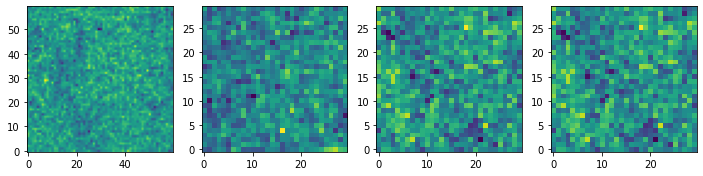

In [8]:
# Measurement of RMS sky noise near every star
sky1 = data[1:241, (y_s1-r_psf_sub*2-10):(y_s1+r_psf_sub*2-10), 
                (x_s1-r_psf_sub*2-100):(x_s1+r_psf_sub*2-100)].sum(axis=0)*1.25

sky2 = data[1:241, (y_s2-r_psf_sub-10):(y_s2+r_psf_sub+-10), 
                (x_s2-r_psf_sub-30):(x_s2+r_psf_sub-30)].sum(axis=0)*1.25

sky3 = data[1:241, (y_s3-r_psf_sub):(y_s3+r_psf_sub), 
                (x_s3-r_psf_sub+50):(x_s3+r_psf_sub+50)].sum(axis=0)*1.25

sky4 = data[1:241, (y_s3-r_psf_sub):(y_s3+r_psf_sub), 
                (x_s3-r_psf_sub+50):(x_s3+r_psf_sub+50)].sum(axis=0)*1.25       # QSO sky! 

RMS1 = np.sqrt(np.mean(sky1**2))
RMS2 = np.sqrt(np.mean(sky2**2))
RMS3 = np.sqrt(np.mean(sky3**2))
RMS4 = np.sqrt(np.mean(sky4**2))

plt.figure(figsize=(12,8))
plt.subplot(141)
plt.imshow(sky1, origin='lower')
plt.subplot(142)
plt.imshow(sky2, origin='lower')
plt.subplot(143)
plt.imshow(sky3, origin='lower')
plt.subplot(144)
plt.imshow(sky4, origin='lower')
plt.show()

In [9]:
# Fitting
X, Y = np.meshgrid(x,y)
X2, Y2 = np.meshgrid(x2,y2)
xdata = np.vstack((X.ravel(),Y.ravel()))
xdata2 = np.vstack((X2.ravel(),Y2.ravel()))

In [ ]:
f = lambda X, A, x_off, y_off,alpha_x, alpha_y, beta, off_set: moffat_integrated_func(X, A, x_off, y_off,alpha_x, alpha_y, beta,off_set, Ns=60)

param1, cov1 = curve_fit(f, xdata2, star1_off.ravel(), p0=p0)
print('Terminó el primer fit :D')

param2, cov2 = curve_fit(moffat_integrated_func, xdata, star2_off.ravel(), p0=p0)
print('Terminó el 2do fit :D')

param3, cov3 = curve_fit(moffat_integrated_func, xdata, star3_off.ravel(), p0=p0)
print('Terminó el tercer fit :D')

f_qso = lambda X, A, x_off, y_off,alpha_x, alpha_y, beta: moffat_integrated_func(X, A, x_off, y_off,alpha_x, alpha_y, beta, 0)
guess = np.array([3.48502226e+08, -1.12297134e-01, -3.54697347e-02,  5.11584076e-01, 5.26599340e-01,  2.24434034e+00])  
param_QSO, cov_qso = curve_fit(f_qso, xdata, qso_data.ravel(), p0=guess)

print("Terminó el fit :D")

In [13]:
# Performing the fitting with the double component moffat PSF (fixed theta = pi/4).
#A1, A2, x_off, y_off, alpha_x1, alpha_x2, alpha_y1, alpha_y2, beta1, beta2, off_set
p0_double = np.array([4.55544783e+05, 4.55544783e+05, 0., 0., -5.09779583e-01, 0.1, 5.26201887e-01, 0.1, 2.27797444e+00, 2.0, 0.])

f = lambda X, A1, A2, x_off, y_off, alpha_x1, alpha_x2, alpha_y1, alpha_y2, beta1, beta2, off_set: double_moffat_integrated_func(X,  
                        A1, A2, x_off, y_off, alpha_x1, alpha_x2, alpha_y1, alpha_y2, beta1, beta2, off_set, np.pi/4)

f2 = lambda X, A1, A2, x_off, y_off, alpha_x1, alpha_x2, alpha_y1, alpha_y2, beta1, beta2, off_set: double_moffat_integrated_func(X,  
                        A1, A2, x_off, y_off, alpha_x1, alpha_x2, alpha_y1, alpha_y2, beta1, beta2, off_set, np.pi/4, Ns=60)

#param_s1, cov1 = curve_fit(f2, xdata2, star1_off.ravel(), p0=p0_double)
print('Terminó el 1er fit :D')

param_s2, cov2 = curve_fit(f, xdata, star2_off.ravel(), p0=p0_double)
print('Terminó el 2do fit :D')

param_s3, cov3 = curve_fit(f, xdata, star3_off.ravel(), p0=p0_double)
print('Terminó el 2do fit :D')

param_QSO, cov_qso = curve_fit(f, xdata, qso_data.ravel(), p0=p0_double)
print('Terminó el fitteo')

Terminó el 1er fit :D
Terminó el 2do fit :D
Terminó el 2do fit :D
Terminó el fitteo


In [15]:
print( param_s2, param_s3, param_QSO)

[ 3.87073677e+05  1.23798550e+04 -2.01189865e-02 -3.09848969e-02
 -5.33170988e-01  7.36662963e-02  5.51489005e-01  2.56412053e-01
  2.43537483e+00  6.93032869e-01 -1.45180962e+02] [ 1.64179528e+05  2.68101052e+04 -1.85969029e-01 -5.71894552e-02
 -5.70504321e-01 -5.58984381e-01  4.80087973e-01 -1.12349153e+00
  1.47700430e+00  1.49625041e+00 -1.16066826e+03] [ 8.49781073e+04  5.85170144e+06 -8.21727370e-02 -3.64165157e-02
 -6.07705424e-02  4.99253326e-01  2.25250464e-01  5.07881935e-01
  3.64219387e-01  2.33040691e+00  1.44109433e+03]


In [65]:
# Performing the fitting with the double component moffat PSF (unfixed theta).
#A1, A2, x_off, y_off, alpha_x1, alpha_x2, alpha_y1, alpha_y2, beta1, beta2, off_set
p0_double_unfix = np.array([4.55544783e+05, 4.55544783e+05, 0., 0., -5.09779583e-01, 0.1, 5.26201887e-01, 0.1, 
                            2.27797444e+00, 2.0, 0. , np.pi/4])
                            
f2_unfix = lambda X, A1, A2, x_off, y_off, alpha_x1, alpha_x2, alpha_y1, alpha_y2, beta1, beta2, off_set, theta: double_moffat_integrated_func(X,  
                        A1, A2, x_off, y_off, alpha_x1, alpha_x2, alpha_y1, alpha_y2, beta1, beta2, off_set, theta, Ns=60)

#param_s1, cov1 = curve_fit(f2_unfix, xdata2, star1_off.ravel(), p0=p0_double_unfix)
#print('Terminó el 1er fit :D')

#param_s2, cov2 = curve_fit(double_moffat_integrated_func, xdata, star2_off.ravel(), p0=param_s3)
#print('Terminó el 2do fit :D')

param_s3, cov3 = curve_fit(double_moffat_integrated_func, xdata, star3_off.ravel(), p0=param_s2)
print('Terminó el 3er fit :D')

#param_QSO, cov_qso = curve_fit(double_moffat_integrated_func, xdata, qso_data.ravel(), p0=p0_double_unfix)
print('Terminó el fitteo')

Terminó el 3er fit :D
Terminó el fitteo


In [63]:
print(param_s2)

[ 3.92752049e+05  1.26313850e+03 -2.01444492e-02 -3.10212658e-02
 -5.18547677e-01 -4.12899458e+00  5.40721463e-01 -9.17267212e+01
  2.35721446e+00  1.48809239e+03  3.03156627e+01 -4.16092942e+07]


In [72]:
# Previously found parameters (single moffat component): 
param_s1 = np.array([3.48502226e+08, -1.12297134e-01, -3.54697347e-02,  5.11584076e-01, 5.26599340e-01,  2.24434034e+00, 0.])
param_s2 = np.array([4.55544783e+05, -1.93387190e-02, -3.04570226e-02, -5.09779583e-01, 5.26201887e-01,  2.27797444e+00, 0.])
param_s3 = np.array([1.82898132e+05, -1.88034975e-01, -5.90714589e-02, -6.47519030e-01, 5.61422674e-01,  1.63870390e+00, 0.])
param_QSO = np.array([5.97568233e+06, -8.21288585e-02, -3.63930883e-02,  4.63887089e-01, 4.70755322e-01,  2.09210693e+00, 0.])

In [71]:
# Params found for double component (fixed center and fixed rotation)
param_s1_rot = np.array([6.60394368e+06,  3.80636799e+06, -9.11462332e+02,  1.22297910e+02,
                        2.11118175e+02, -8.84037642e+01, -2.98544576e+02, -1.36828866e+02,
                        1.43157979e+01,  2.94355502e+00,  1.64586862e+06])  #not good parameters 

param_s2_rot = np.array([3.87073677e+05,  1.23798550e+04, -2.01189865e-02, -3.09848969e-02,
                        -5.33170988e-01,  7.36662963e-02,  5.51489005e-01,  2.56412053e-01,
                        2.43537483e+00,  6.93032869e-01, -1.45180962e+02])

param_s3_rot = np.array([1.64179528e+05,  2.68101052e+04, -1.85969029e-01, -5.71894552e-02,
                        -5.70504321e-01, -5.58984381e-01,  4.80087973e-01, -1.12349153e+00,
                        1.47700430e+00,  1.49625041e+00, -1.16066826e+03])

param_QSO_rot =  np.array([8.49781073e+04,  5.85170144e+06,-8.21727370e-02, -3.64165157e-02,
                        -6.07705424e-02,  4.99253326e-01, 2.25250464e-01,  5.07881935e-01,
                        3.64219387e-01,  2.33040691e+00,  1.44109433e+03])

In [70]:
# Params found for double component (fixed center and unfixed rotation)
param_s1_rot_unfix = np.array([6.60394368e+06,  8.68081027e+06, -9.33982601e+02,  3.73376647e+02,
                                2.11118175e+02, -8.42911344e+01, -2.98544576e+02, -2.81623693e+02,
                                1.43157979e+01,  2.98085212e+00,  1.64586862e+06,  9.87275961e-01]) # not good parameters! 

param_s2_rot_unfix = np.array([3.95305296e+05,  3.13233071e+04, -2.01203581e-02, -3.09409101e-02,
                                -5.19679117e-01, -3.69904902e-03,  5.36899805e-01,  9.08972551e-02,
                                2.34809569e+00,  1.87592002e+00,  2.31446658e+01,  6.03241434e+07])

param_s3_rot_unfix = np.array([1.70851816e+05,  2.15103142e+04, -1.85814111e-01, -5.68501425e-02,
                                -5.29222806e-01,  1.66219213e+02,  4.97449030e-01, 3.56892337e+02,
                                1.55409915e+00,  5.19187138e+04, -3.40748870e+02, -4.16092940e+07])

param_QSO_rot_unfix =  np.array([2.81714110e+06,  3.06150894e+06, -8.21212734e-02, -3.63980574e-02,
                                -8.00512679e-01,  6.64092843e-01,  8.04783580e-01,  6.85314768e-01,
                                7.90660549e+00,  2.59428541e+00,  9.51055539e+03,  3.60093320e+00,])

In [74]:
# PSF for single component moffat profile.
A1, x_off1, y_off1, alpha_x1, alpha_y1, beta1, off_set1 = param_s1
A2, x_off2, y_off2, alpha_x2, alpha_y2, beta2, off_set1 = param_s2
A3, x_off3, y_off3, alpha_x3, alpha_y3, beta3, off_set1 = param_s3
A_qso, x_off_qso, y_off_qso, alpha_x_qso, alpha_y_qso, beta_qso, off_set_qso = param_QSO

psf_s1 = moffat_integrated_func(xdata2, A1, x_off1, y_off1, alpha_x1, alpha_y1, beta1, off_set1 ,delta_x=0.2, delta_y=0.2, method='scipy', Ns=60)
psf_s2 = moffat_integrated_func(xdata, A2, x_off2, y_off2, alpha_x2, alpha_y2, beta2, off_set1 ,delta_x=0.2, delta_y=0.2, method='scipy')
psf_s3 = moffat_integrated_func(xdata, A3, x_off3, y_off3, alpha_x3, alpha_y3, beta3, off_set1 ,delta_x=0.2, delta_y=0.2, method='scipy')
psf_QSO = moffat_integrated_func(xdata, A_qso, x_off_qso, y_off_qso, alpha_x_qso, alpha_y_qso, beta_qso, off_set_qso,delta_x=0.2, delta_y=0.2, method='scipy')

psf_s1 = psf_s1.reshape(60,60)
psf_s2 = psf_s2.reshape(30,30)
psf_s3 = psf_s3.reshape(30,30)
psf_qso = psf_QSO.reshape(30,30)

In [75]:
# Creating the PSF for the double component Moffat. (fixed rotation)
A1_qso, A2_qso, x_off_qso, y_off_qso, alpha_x1_qso, alpha_x2_qso, alpha_y1_qso, alpha_y2_qso, beta1_qso, beta2_qso, off_set_qso = param_QSO_rot
A1_s1, A2_s1, x_off_s1, y_off_s1, alpha_x1_s1, alpha_x2_s1, alpha_y1_s1, alpha_y2_s1, beta1_s1, beta2_s1, off_set_s1 = param_s1_rot
A1_s2, A2_s2, x_off_s2, y_off_s2, alpha_x1_s2, alpha_x2_s2, alpha_y1_s2, alpha_y2_s2, beta1_s2, beta2_s2, off_set_s2 = param_s2_rot
A1_s3, A2_s3, x_off_s3, y_off_s3, alpha_x1_s3, alpha_x2_s3, alpha_y1_s3, alpha_y2_s3, beta1_s3, beta2_s3, off_set_s3 = param_s3_rot

psf_qso_rot = double_moffat_integrated_func(xdata, A1_qso, A2_qso, x_off_qso, y_off_qso, alpha_x1_qso, alpha_x2_qso, alpha_y1_qso,
                alpha_y2_qso, beta1_qso, beta2_qso, off_set_qso, np.pi/4, delta_x=0.2, delta_y=0.2, method='scipy', Ns=30)

psf_s1_rot = double_moffat_integrated_func(xdata2, A1_s1, A2_s1, x_off_s1, y_off_s1, alpha_x1_s1, alpha_x2_s1, alpha_y1_s1, alpha_y2_s1,
                beta1_s1, beta2_s1, off_set_s1, np.pi/4, delta_x=0.2, delta_y=0.2, method='scipy', Ns=60)

psf_s2_rot = double_moffat_integrated_func(xdata, A1_s2, A2_s2, x_off_s2, y_off_s2, alpha_x1_s2, alpha_x2_s2, alpha_y1_s2, alpha_y2_s2,
                beta1_s2, beta2_s2, off_set_s2, np.pi/4, delta_x=0.2, delta_y=0.2, method='scipy', Ns=30)

psf_s3_rot = double_moffat_integrated_func(xdata, A1_s3, A2_s3, x_off_s3, y_off_s3, alpha_x1_s3, alpha_x2_s3, alpha_y1_s3, alpha_y2_s3,
                beta1_s3, beta2_s3, off_set_s3, np.pi/4, delta_x=0.2, delta_y=0.2, method='scipy', Ns=30)

psf_qso_rot = psf_qso_rot.reshape(30,30)
psf_s1_rot = psf_s1_rot.reshape(60,60)
psf_s2_rot = psf_s2_rot.reshape(30,30)
psf_s3_rot = psf_s3_rot.reshape(30,30)

In [77]:
# Creating the PSF for the double component Moffat. (unfixed rot_unfixation)
A1_qso, A2_qso, x_off_qso, y_off_qso, alpha_x1_qso, alpha_x2_qso, alpha_y1_qso, alpha_y2_qso, beta1_qso, beta2_qso, off_set_qso, theta_qso = param_QSO_rot_unfix
#A1_s1, A2_s1, x_off_s1, y_off_s1, alpha_x1_s1, alpha_x2_s1, alpha_y1_s1, alpha_y2_s1, beta1_s1, beta2_s1, off_set_s1, theta_s1 = param_s1_rot_unfix
A1_s2, A2_s2, x_off_s2, y_off_s2, alpha_x1_s2, alpha_x2_s2, alpha_y1_s2, alpha_y2_s2, beta1_s2, beta2_s2, off_set_s2, theta_s2 = param_s2_rot_unfix
A1_s3, A2_s3, x_off_s3, y_off_s3, alpha_x1_s3, alpha_x2_s3, alpha_y1_s3, alpha_y2_s3, beta1_s3, beta2_s3, off_set_s3, theta_s3 = param_s3_rot_unfix

psf_qso_rot_unfix = double_moffat_integrated_func(xdata, A1_qso, A2_qso, x_off_qso, y_off_qso, alpha_x1_qso, alpha_x2_qso, alpha_y1_qso,
                alpha_y2_qso, beta1_qso, beta2_qso, off_set_qso, theta_qso, delta_x=0.2, delta_y=0.2, method='scipy', Ns=30)

#psf_s1_rot_unfix = double_moffat_integrated_func(xdata2, A1_s1, A2_s1, x_off_s1, y_off_s1, alpha_x1_s1, alpha_x2_s1, alpha_y1_s1, alpha_y2_s1,
#                beta1_s1, beta2_s1, off_set_s1, theta_s1, delta_x=0.2, delta_y=0.2, method='scipy', Ns=60)

psf_s2_rot_unfix = double_moffat_integrated_func(xdata, A1_s2, A2_s2, x_off_s2, y_off_s2, alpha_x1_s2, alpha_x2_s2, alpha_y1_s2, alpha_y2_s2,
                beta1_s2, beta2_s2, off_set_s2, theta_s2, delta_x=0.2, delta_y=0.2, method='scipy', Ns=30)

psf_s3_rot_unfix = double_moffat_integrated_func(xdata, A1_s3, A2_s3, x_off_s3, y_off_s3, alpha_x1_s3, alpha_x2_s3, alpha_y1_s3, alpha_y2_s3,
                beta1_s3, beta2_s3, off_set_s3, theta_s3, delta_x=0.2, delta_y=0.2, method='scipy', Ns=30)

psf_qso_rot_unfix = psf_qso_rot_unfix.reshape(30,30)
#psf_s1_rot_unfix = psf_s1_rot_unfix.reshape(60,60)
psf_s2_rot_unfix = psf_s2_rot_unfix.reshape(30,30)
psf_s3_rot_unfix = psf_s3_rot_unfix.reshape(30,30)

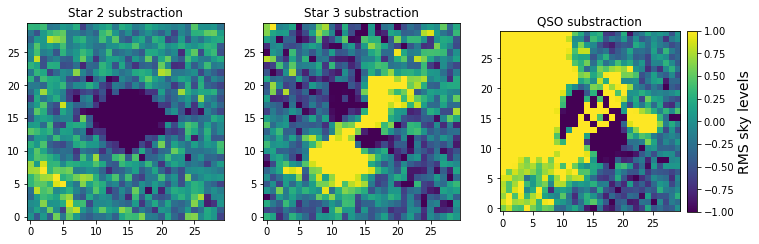

In [78]:
# Checking fits

diff_s1 = star1_off - psf_s1
diff_s2 = star2_off - psf_s2
diff_s3 = star3_off - psf_s3
diff_qso = qso_data - psf_qso

plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(diff_s2/RMS2, origin='lower')
plt.title('Star 2 substraction')
plt.clim(-1,1)

plt.subplot(132)
plt.imshow(diff_s3/RMS3, origin='lower')
plt.title('Star 3 substraction')
plt.clim(-1,1)

plt.subplot(133)
plt.imshow(diff_qso/RMS4, origin='lower')
plt.title('QSO substraction')
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label('RMS sky levels', fontsize=14)
plt.clim(-1,1)

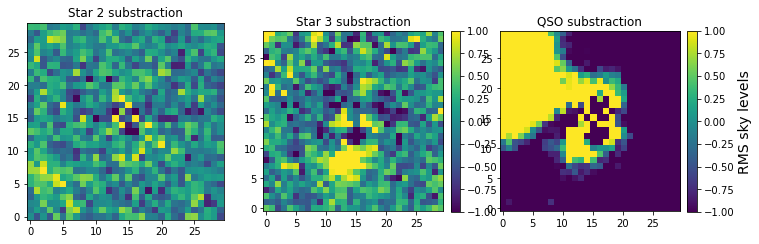

In [79]:
# Checking fits  (double component fixed rotation)

diff_s1 = star1_off - psf_s1_rot
diff_s2 = star2_off - psf_s2_rot
diff_s3 = star3_off - psf_s3_rot
diff_qso = qso_data - psf_qso_rot

plt.figure(figsize=(12,8))
#plt.subplot(141)
#plt.imshow(psf_s1_rot, origin='lower')
#plt.title('Star 1 substraction')
#plt.clim(-100,10000)

plt.subplot(131)
plt.imshow(diff_s2/RMS2, origin='lower')
plt.title('Star 2 substraction')
plt.clim(-1,1)

plt.subplot(132)
plt.imshow(diff_s3/RMS3, origin='lower')
plt.title('Star 3 substraction')
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label('RMS sky levels', fontsize=14)
plt.clim(-1,1)

plt.subplot(133)
plt.imshow(diff_qso/RMS4, origin='lower')
plt.title('QSO substraction')
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label('RMS sky levels', fontsize=14)
plt.clim(-1,1)

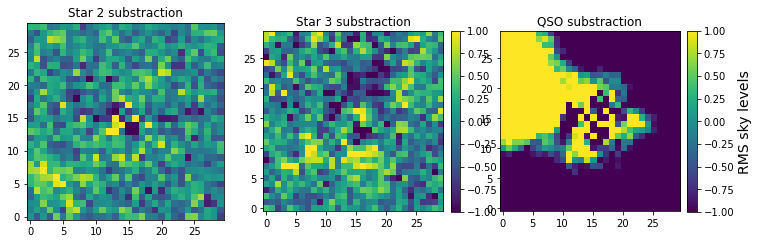

In [80]:
# Checking fits  (double component unfixed rotation)

#diff_s1 = star1_off - psf_s1_rot_unfix
diff_s2 = star2_off - psf_s2_rot_unfix
diff_s3 = star3_off - psf_s3_rot_unfix
diff_qso = qso_data - psf_qso_rot_unfix

plt.figure(figsize=(12,8))
#plt.subplot(131)
#plt.imshow(diff_s1/RMS1, origin='lower')
#plt.title('Star 1 substraction')
#plt.clim(-1,1)

plt.subplot(131)
plt.imshow(diff_s2/RMS2, origin='lower')
plt.title('Star 2 substraction')
plt.clim(-1,1)

plt.subplot(132)
plt.imshow(diff_s3/RMS3, origin='lower')
plt.title('Star 3 substraction')
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label('RMS sky levels', fontsize=14)
plt.clim(-1,1)

plt.subplot(133)
plt.imshow(diff_qso/RMS4, origin='lower')
plt.title('QSO substraction')
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label('RMS sky levels', fontsize=14)
plt.clim(-1,1)

In [81]:
# Getting the centers of each PSF
psfcen_1 = np.argwhere(psf_qso == np.max(psf_qso))[0]
psfcen_2 = np.argwhere(psf_s2 == np.max(psf_s2))[0]
psfcen_3 = np.argwhere(psf_s3 == np.max(psf_s3))[0]

# PSF centers of fixed rotated double moffat.
psfcen_1_rot = np.argwhere(psf_qso_rot == np.max(psf_qso_rot))[0]
psfcen_2_rot = np.argwhere(psf_s2_rot == np.max(psf_s2_rot))[0]
psfcen_3_rot = np.argwhere(psf_s3_rot == np.max(psf_s3_rot))[0]

# PSF centers of unfixed rotated double moffat.
psfcen_1_rot_unfix = np.argwhere(psf_qso_rot_unfix == np.max(psf_qso_rot_unfix))[0]
psfcen_2_rot_unfix = np.argwhere(psf_s2_rot_unfix == np.max(psf_s2_rot_unfix))[0]
psfcen_3_rot_unfix = np.argwhere(psf_s3_rot_unfix == np.max(psf_s3_rot_unfix))[0]


#Get wavelenth of LyA at QSO redshift
wLyA = 1215.6701 * (1.0+zqso) 
#Create a search windown using minimum/maximm velocities; convert to wavelength
wmin = (1+vmin/2.998e5)*wLyA
wmax = (1+vmax/2.998e5)*wLyA

#Get indicies of this serach windown
windmin = 1
windmax = 161

#Get indicies in steps of wavelength slice
winds = np.arange(windmin, windmax, wave_slice)

print(wmin, wmax)

4750.851185940005 4951.194807868179


In [105]:
sub_img1, img_1, norm1 = flux_scaling(psf_qso, xqso, yqso, psfcen_1, winds, wave_slice, data, r_psf_sub, r_psf_scale)
sub_img2, img_2, norm2 = flux_scaling(psf_s2, y_s2, x_s2, psfcen_2, winds, wave_slice, data, r_psf_sub, r_psf_scale)
sub_img3, img_3, norm3 = flux_scaling(psf_s3, y_s3, x_s3, psfcen_3, winds, wave_slice, data, r_psf_sub, r_psf_scale)

sub_img1_rot, img_1_rot, norm1_rot = flux_scaling(psf_qso_rot, xqso, yqso, psfcen_1_rot, winds, wave_slice, data, r_psf_sub, r_psf_scale)
sub_img2_rot, img_2_rot, norm2_rot = flux_scaling(psf_s2_rot, y_s2, x_s2, psfcen_2_rot, winds, wave_slice, data, r_psf_sub, r_psf_scale)
sub_img3_rot, img_3_rot, norm3_rot = flux_scaling(psf_s3_rot, y_s3, x_s3, psfcen_3_rot, winds, wave_slice, data, r_psf_sub, r_psf_scale)

sub_img1_rot_unfix, img_1_rot_unfix, norm1_rot_unfix = flux_scaling(psf_qso_rot_unfix, xqso, yqso, psfcen_1_rot_unfix, winds, wave_slice, data, r_psf_sub, r_psf_scale)
sub_img2_rot_unfix, img_2_rot_unfix, norm2_rot_unfix = flux_scaling(psf_s2_rot_unfix, y_s2, x_s2, psfcen_2_rot_unfix, winds, wave_slice, data, r_psf_sub, r_psf_scale)
sub_img3_rot_unfix, img_3_rot_unfix, norm3_rot_unfix = flux_scaling(psf_s3_rot_unfix, y_s3, x_s3, psfcen_3_rot_unfix, winds, wave_slice, data, r_psf_sub, r_psf_scale)



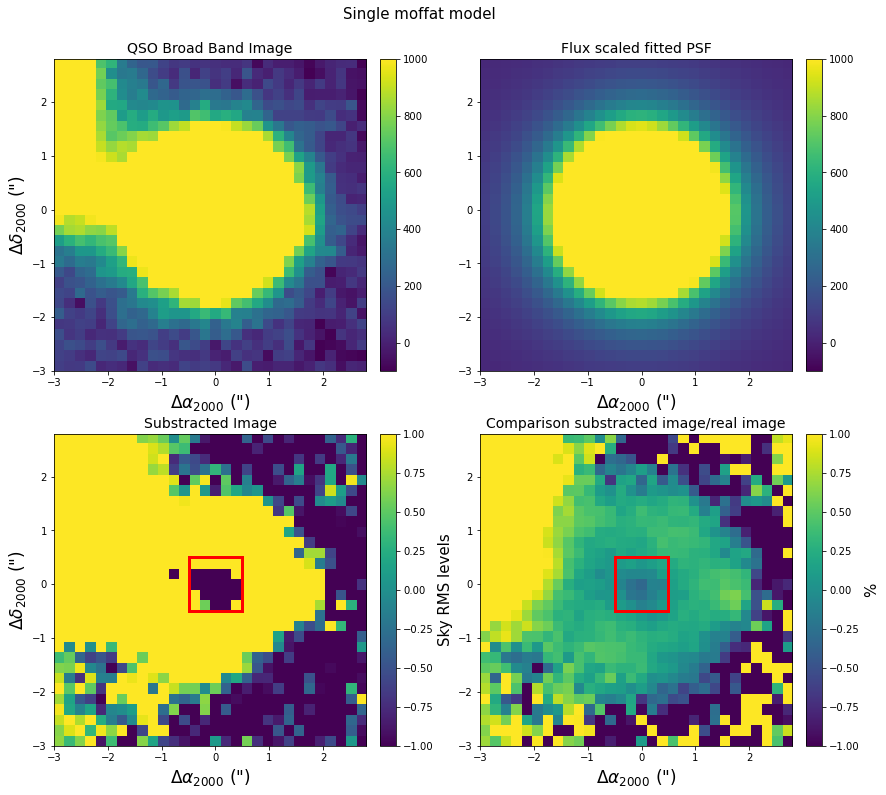

In [151]:
x = np.arange(-15,15)*0.2
y = np.arange(-15,15)*0.2

fig = plt.figure(figsize=(14,12))
plt.subplot(221)
plt.imshow(img_1, origin='lower',extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.colorbar(fraction=0.046, pad=0.04)
plt.clim(-100,1000)
plt.title('QSO Broad Band Image', fontsize=14)

plt.subplot(222)
plt.imshow(psf_qso*norm1, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Flux scaled fitted PSF', fontsize=14)

ax3 =plt.subplot(223)
plt.imshow(sub_img1/RMS4, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax3.add_patch(Rectangle((x[15]-0.5,x[15]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.clim(-1,1)
cb.set_label('Sky RMS levels', fontsize=15)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.title('Substracted Image', fontsize=14)

ax3=plt.subplot(224)
plt.imshow(sub_img1/img_1, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-1,1)
cb = plt.colorbar(fraction=0.046, pad=0.04)
ax3.add_patch(Rectangle((x[15]-0.5,x[15]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
cb.set_label('%', fontsize=15)
plt.title('Comparison substracted image/real image', fontsize=14)

fig.subplots_adjust(top=0.92)
fig.suptitle('Single moffat model', fontsize=15)
plt.show()

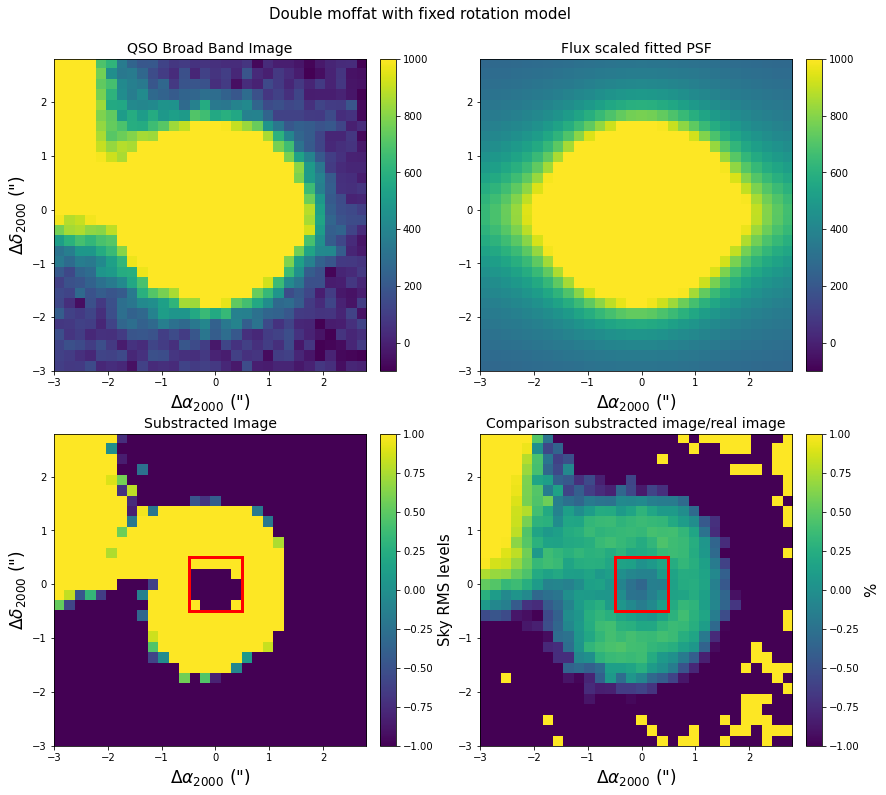

In [150]:
fig = plt.figure(figsize=(14,12))
plt.subplot(221)
plt.imshow(img_1_rot, origin='lower',extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.colorbar(fraction=0.046, pad=0.04)
plt.clim(-100,1000)
plt.title('QSO Broad Band Image', fontsize=14)

plt.subplot(222)
plt.imshow(psf_qso_rot*norm1_rot, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Flux scaled fitted PSF', fontsize=14)

ax3 =plt.subplot(223)
plt.imshow(sub_img1_rot/RMS4, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax3.add_patch(Rectangle((x[15]-0.5,x[15]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.clim(-1,1)
cb.set_label('Sky RMS levels', fontsize=15)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.title('Substracted Image', fontsize=14)

ax3=plt.subplot(224)
plt.imshow(sub_img1_rot/img_1_rot, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-1,1)
cb = plt.colorbar(fraction=0.046, pad=0.04)
ax3.add_patch(Rectangle((x[15]-0.5,x[15]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
cb.set_label('%', fontsize=15)
plt.title('Comparison substracted image/real image', fontsize=14)

fig.subplots_adjust(top=0.92)
fig.suptitle('Double moffat with fixed rotation model', fontsize=15)
plt.show()

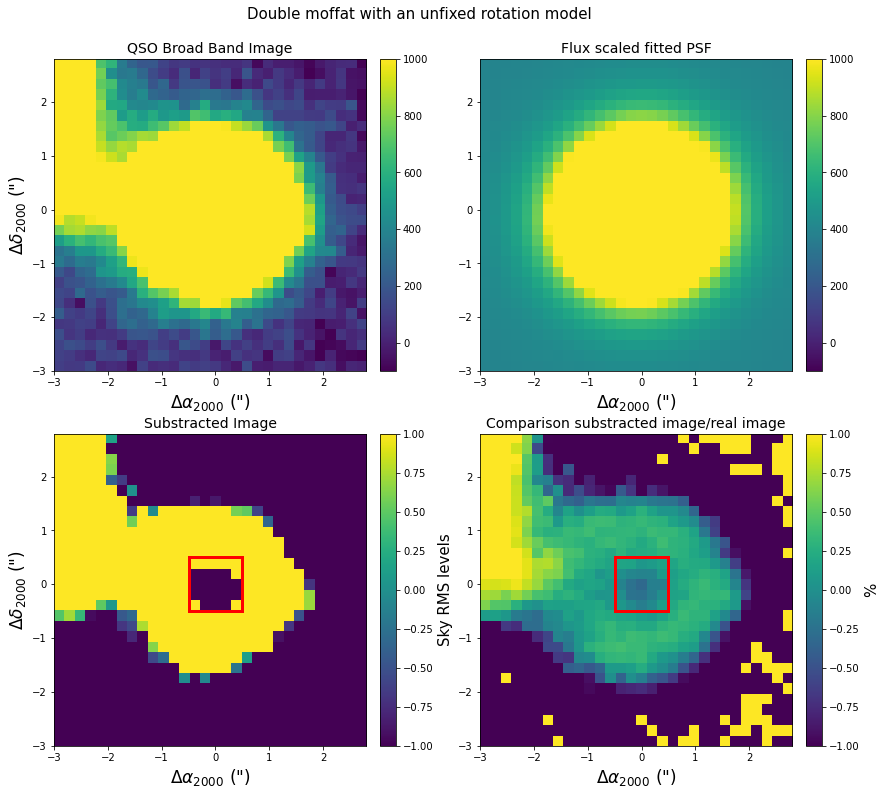

In [149]:
fig = plt.figure(figsize=(14,12))
plt.subplot(221)
plt.imshow(img_1_rot_unfix, origin='lower',extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.colorbar(fraction=0.046, pad=0.04)
plt.clim(-100,1000)
plt.title('QSO Broad Band Image', fontsize=14)

plt.subplot(222)
plt.imshow(psf_qso_rot_unfix*norm1_rot_unfix, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Flux scaled fitted PSF', fontsize=14)

ax3 =plt.subplot(223)
plt.imshow(sub_img1_rot_unfix/RMS4, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax3.add_patch(Rectangle((x[15]-0.5,x[15]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.clim(-1,1)
cb.set_label('Sky RMS levels', fontsize=15)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.title('Substracted Image', fontsize=14)

ax3=plt.subplot(224)
plt.imshow(sub_img1_rot_unfix/img_1_rot_unfix, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-1,1)
cb = plt.colorbar(fraction=0.046, pad=0.04)
ax3.add_patch(Rectangle((x[15]-0.5,x[15]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
cb.set_label('%', fontsize=15)
plt.title('Comparison substracted image/real image', fontsize=14)

fig.subplots_adjust(top=0.92)
fig.suptitle('Double moffat with an unfixed rotation model', fontsize=15)
plt.show()

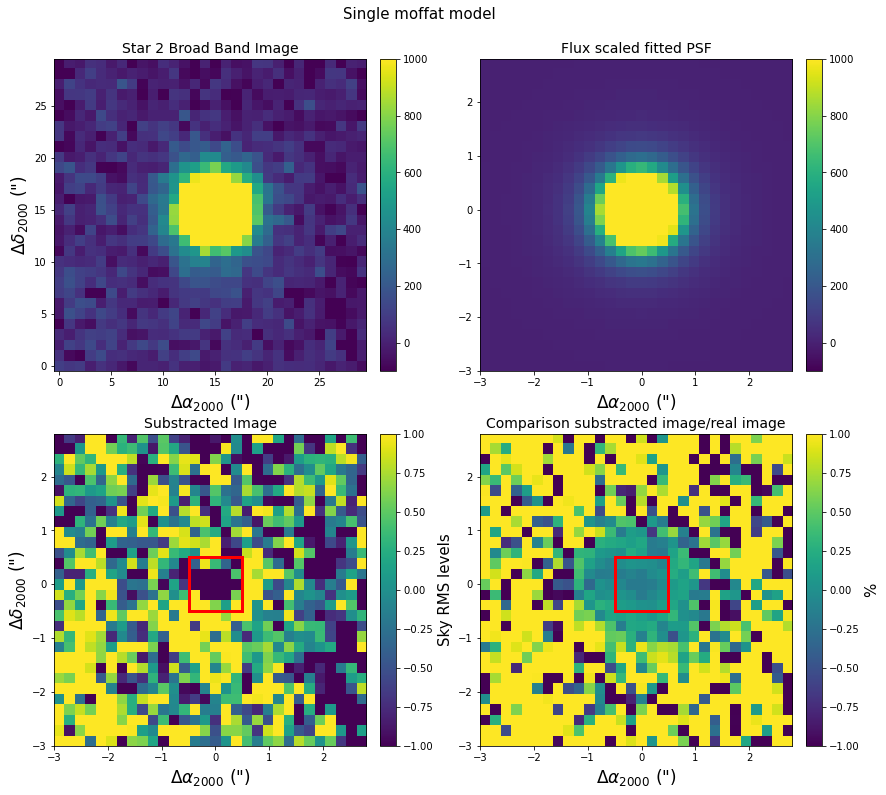

In [148]:
fig = plt.figure(figsize=(14,12))
plt.subplot(221)
plt.imshow(img_2, origin='lower')
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Star 2 Broad Band Image', fontsize=14)

plt.subplot(222)
plt.imshow(psf_s2*norm2, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Flux scaled fitted PSF', fontsize=14)

ax= plt.subplot(223)
plt.imshow(sub_img2/RMS3, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax.add_patch(Rectangle((x[15]-0.5,x[15]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
cb.set_label('Sky RMS levels', fontsize=15)
plt.title('Substracted Image', fontsize=14)
plt.clim(-1,1)


ax=plt.subplot(224)
plt.imshow(sub_img2/img_2, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-1,1)
cb = plt.colorbar(fraction=0.046, pad=0.04)
ax.add_patch(Rectangle((x[15]-0.5,x[15]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.title('Comparison substracted image/real image', fontsize=14)
cb.set_label('%', fontsize=15)

fig.subplots_adjust(top=0.92)
fig.suptitle('Single moffat model', fontsize=15)
plt.show()

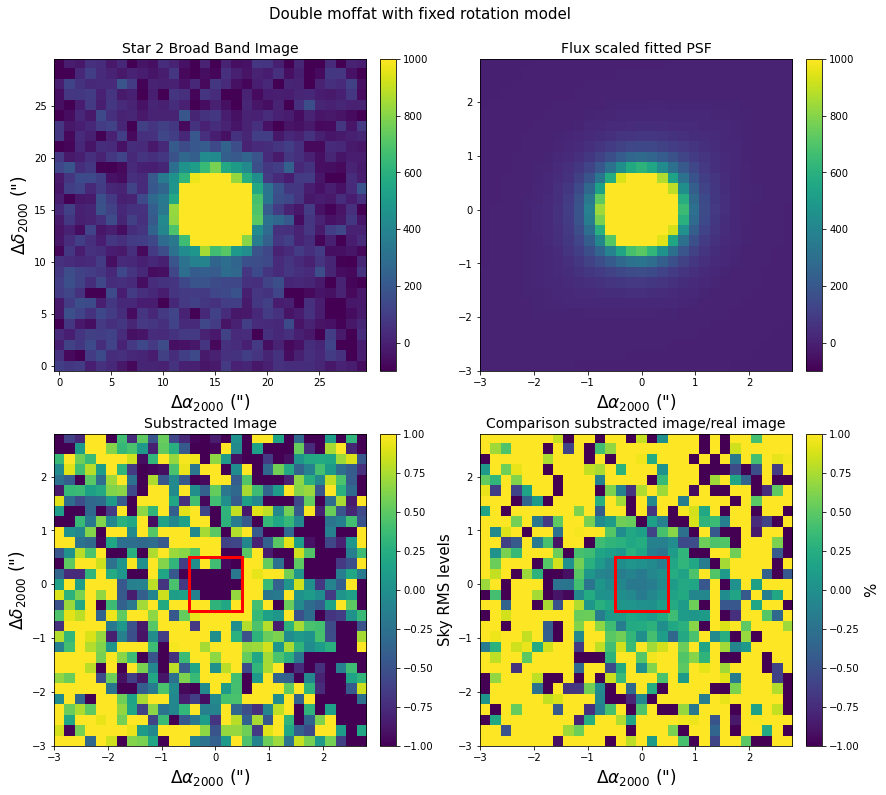

In [147]:
fig = plt.figure(figsize=(14,12))
plt.subplot(221)
plt.imshow(img_2_rot, origin='lower')
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Star 2 Broad Band Image', fontsize=14)

plt.subplot(222)
plt.imshow(psf_s2_rot*norm2_rot, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Flux scaled fitted PSF', fontsize=14)

ax= plt.subplot(223)
plt.imshow(sub_img2_rot/RMS3, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax.add_patch(Rectangle((x[15]-0.5,x[15]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
cb.set_label('Sky RMS levels', fontsize=15)
plt.title('Substracted Image', fontsize=14)
plt.clim(-1,1)


ax=plt.subplot(224)
plt.imshow(sub_img2_rot/img_2_rot, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-1,1)
cb = plt.colorbar(fraction=0.046, pad=0.04)
ax.add_patch(Rectangle((x[15]-0.5,x[15]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.title('Comparison substracted image/real image', fontsize=14)
cb.set_label('%', fontsize=15)

fig.subplots_adjust(top=0.92)
fig.suptitle('Double moffat with fixed rotation model', fontsize=15)
plt.show()

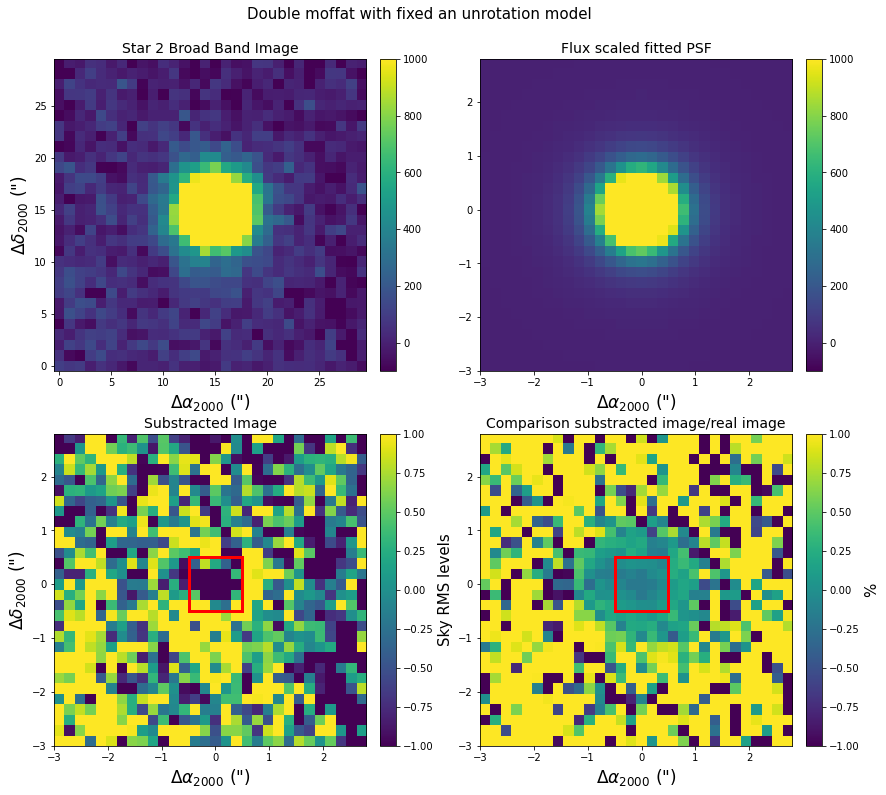

In [146]:
fig = plt.figure(figsize=(14,12))
plt.subplot(221)
plt.imshow(img_2_rot_unfix, origin='lower')
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Star 2 Broad Band Image', fontsize=14)

plt.subplot(222)
plt.imshow(psf_s2_rot_unfix*norm2_rot_unfix, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Flux scaled fitted PSF', fontsize=14)

ax= plt.subplot(223)
plt.imshow(sub_img2_rot_unfix/RMS3, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax.add_patch(Rectangle((x[15]-0.5,x[15]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
cb.set_label('Sky RMS levels', fontsize=15)
plt.title('Substracted Image', fontsize=14)
plt.clim(-1,1)


ax=plt.subplot(224)
plt.imshow(sub_img2_rot_unfix/img_2_rot_unfix, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-1,1)
cb = plt.colorbar(fraction=0.046, pad=0.04)
ax.add_patch(Rectangle((x[15]-0.5,x[15]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.title('Comparison substracted image/real image', fontsize=14)
cb.set_label('%', fontsize=15)

fig.subplots_adjust(top=0.92)
fig.suptitle('Double moffat with fixed an unrotation model', fontsize=15)
plt.show()

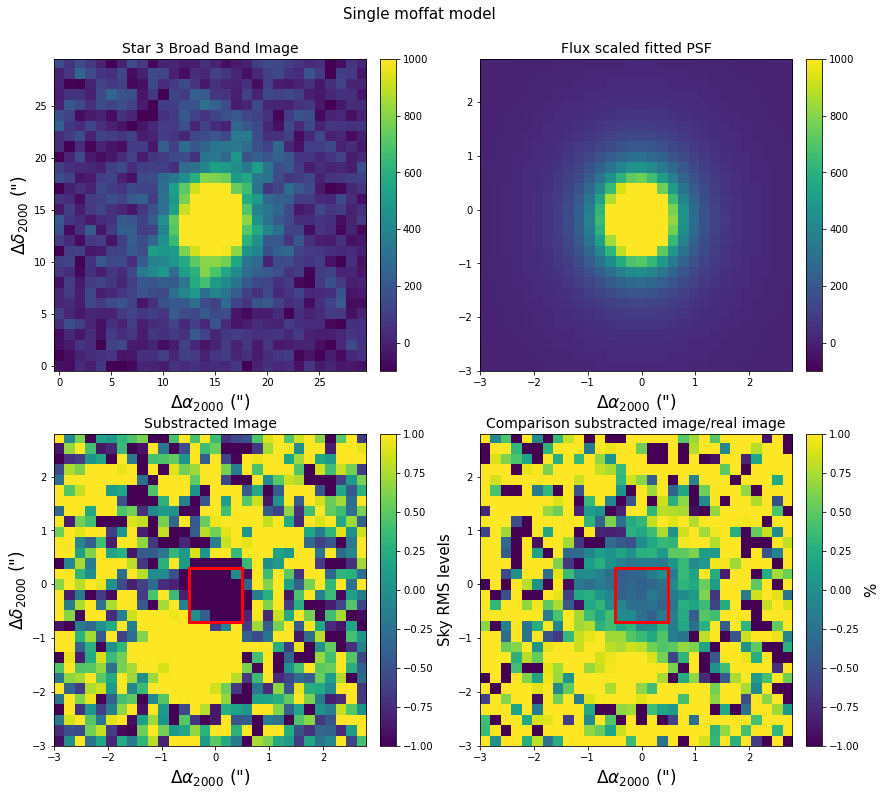

In [145]:
fig = plt.figure(figsize=(14,12))
plt.subplot(221)
plt.imshow(img_3, origin='lower')
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Star 3 Broad Band Image', fontsize=14)

plt.subplot(222)
plt.imshow(psf_s3*norm3, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Flux scaled fitted PSF', fontsize=14)

ax2 = plt.subplot(223)
plt.imshow(sub_img3/RMS3, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax2.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
cb.set_label('Sky RMS levels', fontsize=15)
plt.title('Substracted Image', fontsize=14)
plt.clim(-1,1)

ax=plt.subplot(224)
plt.imshow(sub_img3/img_3, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-1,1)
cb = plt.colorbar(fraction=0.046, pad=0.04)
ax.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.title('Comparison substracted image/real image', fontsize=14)
cb.set_label('%', fontsize=15)

fig.subplots_adjust(top=0.92)
fig.suptitle('Single moffat model', fontsize=15)
plt.show()

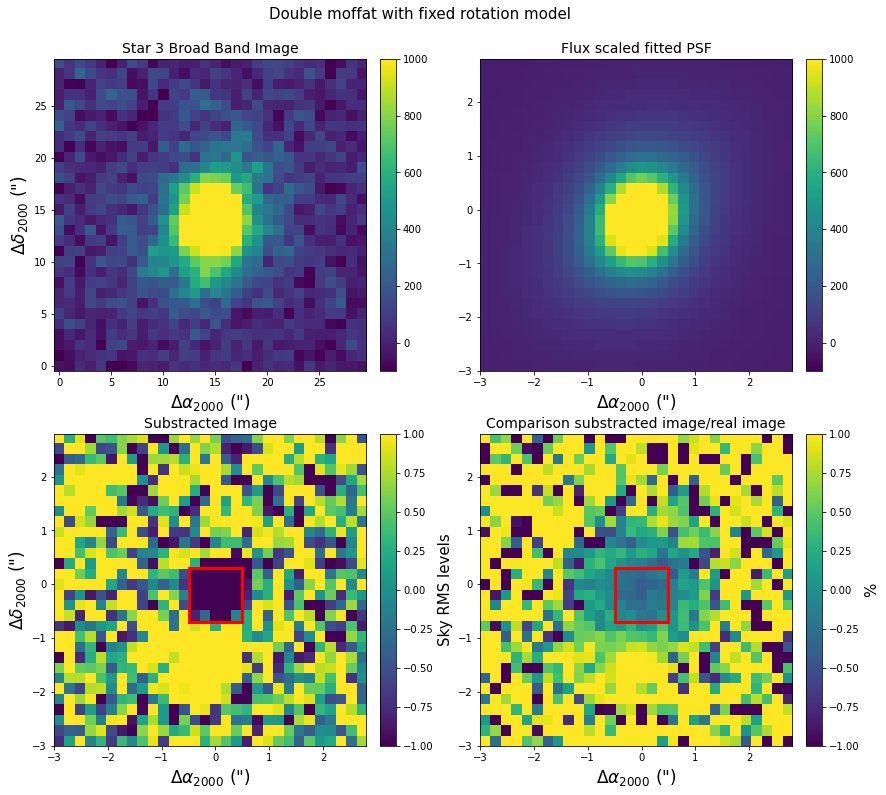

In [143]:
fig = plt.figure(figsize=(14,12))
plt.subplot(221)
plt.imshow(img_3_rot, origin='lower')
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Star 3 Broad Band Image', fontsize=14)

plt.subplot(222)
plt.imshow(psf_s3_rot*norm3, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Flux scaled fitted PSF', fontsize=14)

ax2 = plt.subplot(223)
plt.imshow(sub_img3_rot/RMS3, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax2.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
cb.set_label('Sky RMS levels', fontsize=15)
plt.title('Substracted Image', fontsize=14)
plt.clim(-1,1)

ax=plt.subplot(224)
plt.imshow(sub_img3_rot/img_3_rot, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-1,1)
cb = plt.colorbar(fraction=0.046, pad=0.04)
ax.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.title('Comparison substracted image/real image', fontsize=14)
cb.set_label('%', fontsize=15)

fig.subplots_adjust(top=0.92)
fig.suptitle('Double moffat with fixed rotation model', fontsize=15)
plt.show()

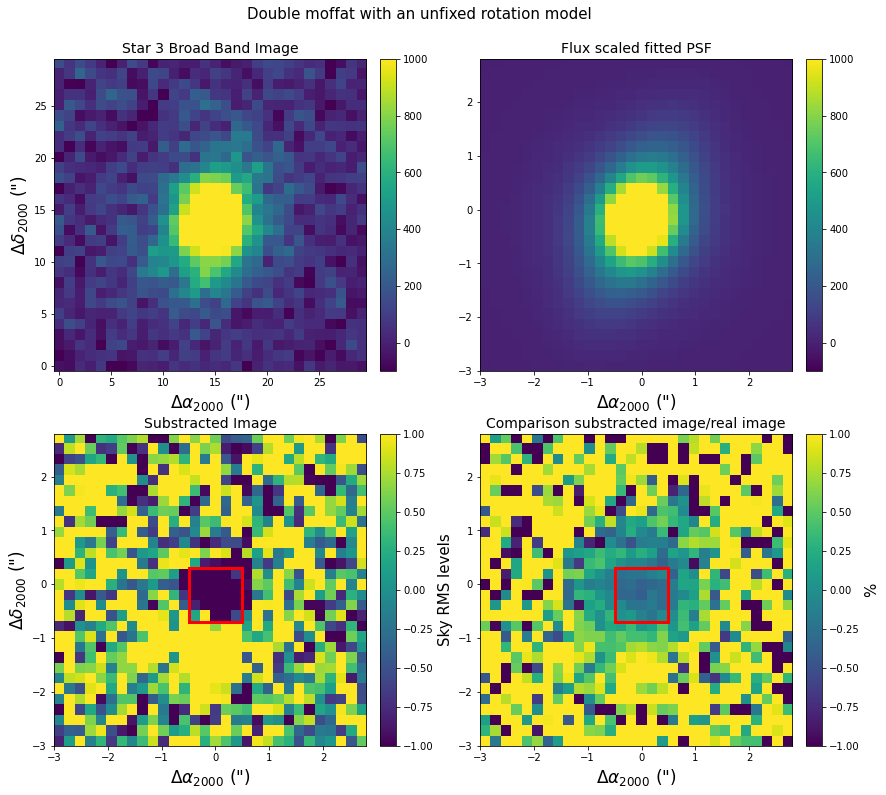

In [144]:
fig = plt.figure(figsize=(14,12))
plt.subplot(221)
plt.imshow(img_3_rot_unfix, origin='lower')
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Star 3 Broad Band Image', fontsize=14)

plt.subplot(222)
plt.imshow(psf_s3_rot_unfix*norm3_rot_unfix, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Flux scaled fitted PSF', fontsize=14)

ax2 = plt.subplot(223)
plt.imshow(sub_img3_rot_unfix/RMS3, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax2.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
cb.set_label('Sky RMS levels', fontsize=15)
plt.title('Substracted Image', fontsize=14)
plt.clim(-1,1)

ax=plt.subplot(224)
plt.imshow(sub_img3_rot_unfix/img_3_rot_unfix, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-1,1)
cb = plt.colorbar(fraction=0.046, pad=0.04)
ax.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.title('Comparison substracted image/real image', fontsize=14)
cb.set_label('%', fontsize=15)

fig.subplots_adjust(top=0.92)
fig.suptitle('Double moffat with an unfixed rotation model', fontsize=15)
plt.show()

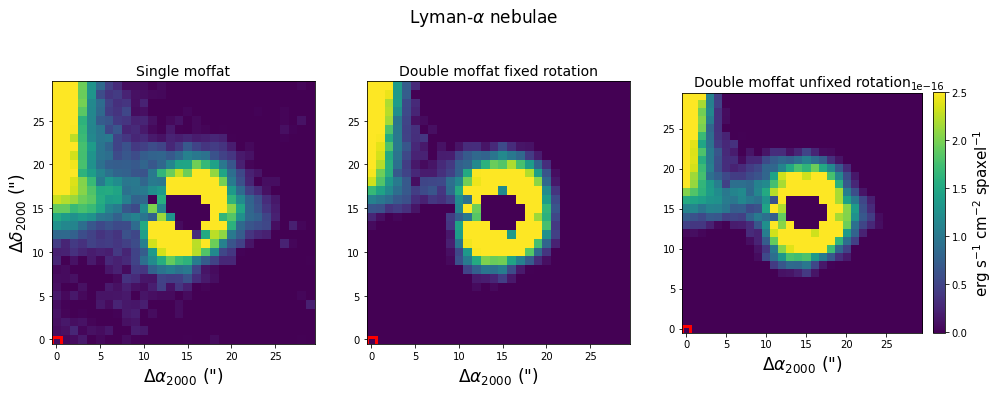

In [163]:
# Final image of the nebulae
scaling_factor = 10e-20
plt.figure(figsize=(16,6))

ax2 = plt.subplot(131)
plt.imshow(sub_img1*scaling_factor, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax2.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.title(r'Single moffat', fontsize=14)
plt.clim(-10*scaling_factor,2500*scaling_factor)

ax3 = plt.subplot(132)
plt.imshow(sub_img1_rot*scaling_factor, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax3.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.title(r'Double moffat fixed rotation', fontsize=14)
plt.clim(-10*scaling_factor,2500*scaling_factor)

ax4 = plt.subplot(133)
plt.imshow(sub_img1_rot_unfix*scaling_factor, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax4.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
cb.set_label(r'erg s$^{-1}$ cm$^{-2}$ spaxel$^{-1}$', fontsize=15)
plt.title(r'Double moffat unfixed rotation', fontsize=14)
plt.clim(-10*scaling_factor,2500*scaling_factor)


plt.suptitle(r'Lyman-$\alpha$ nebulae', fontsize=17)

plt.show()

In [160]:
from astropy.cosmology import FlatLambdaCDM
from astropy import coordinates as coord
from astropy import units as u

In [164]:
#Set the cosmology
cosmo = FlatLambdaCDM(H0=67.8, Om0=0.308)

RA_qso = "13:56:46.832"
DEC_qso = "-11:01:29.37"
coord_qso = coord.SkyCoord(ra=RA_qso, dec=DEC_qso, frame='fk5', unit=(u.hourangle, u.deg))

scale = cosmo.arcsec_per_kpc_proper(zqso).value

RA_nebulae_1 =  "13:56:46.832"
DEC_nebulae_1 = "-11:01:28.37"

RA_nebulae_2 =  "13:56:46.832"
DEC_nebulae_2 = "-11:01:30.57"

coord_1 = coord.SkyCoord(ra=RA_nebulae_1, dec=DEC_nebulae_1, frame='fk5', unit=(u.hourangle, u.deg))
coord_2 = coord.SkyCoord(ra=RA_nebulae_2, dec=DEC_nebulae_2, frame='fk5', unit=(u.hourangle, u.deg))

angsep = coord_1.separation(coord_2).degree

rho = np.abs(angsep/(scale/3600.0))

print("The projected Ly alpha diameter is: {:2f} kpc".format(rho))

The projected Ly alpha diameter is: 17.351112 kpc
